In [67]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import itertools
import numpy as np
import time
import pickle as pkl
import sys

sys.path.insert(0, '..')
from livexiv.efficient_eval import *

ms = [3,5,8,12]
versions_list = [['old','v1'],['v1','v2','v3_s0'],['v1','v2','v3_s1'],['v1','v2','v3_s2'],['v1','v2','v3_s0','v4'],['v1','v2','v3','v4']]
names = ['vqa','tqa']

models_names = ['InstructBLIP-7B',
                'InternLM-Xcomposer2.5-7B',
                'InternVL2-2B',
                'InternVL2-8B',
                'LLaVA-1.6-Mistral-7B',
                'LLaVA-OneVision-Qwen2-7B',
                'LLaVA-1.5-13B',
                'LLaVA-1.6-7B',
                'LLaVA-1.6-34B',
                'Mantis-LLama3-8B',
                'Phi3v',
                'InternLM-Xcomposer2-4KHD-7B',
                'Idefics2-8B',
                'Claude-Sonnet',
                'Qwen2-VL',
                'GPT-4o',
                'Idefics3',
                'NewModel1',
                'NewModel2']

def get_Y_domain(data, domain):
    if domain in data.keys():
        return data[domain]
    else:
        return np.array([[]])

def get_Y(data, domains):
    Y = []
    for domain in domains:
        y = get_Y_domain(data, domain)
        if y.shape[1]>0:
            Y.append(y)
    return np.hstack(Y)

In [68]:
Ys_hat = {}
Ys = {}
models = {}
errors_dict = {}
corrs_dict = {}

for m in ms:
    Ys_hat[m] = {}
    Ys[m] = {}
    models[m] = {}
    errors_dict[m] = {}
    corrs_dict[m] = {}

    for versions in versions_list: #
        Ys_hat[m]["_".join(versions)] = {}
        Ys[m]["_".join(versions)] = {}
        models[m]["_".join(versions)] = {}
        errors_dict[m]["_".join(versions)] = {}
        corrs_dict[m]["_".join(versions)] = {}
    
        versions = [v for v in versions if v]
        vs = list(range(len(versions)))

        data = {}
        Y = {}
        domain_counts = {}
        domain_inds = {}
        
        
        for name in names:
            print(f'******************************** versions={versions} name={name} m={m} ********************************\n')
            
            data[name] = {}
            domain_counts[name] = {}
            domain_inds[name] = {}
            Y[name] = {}

            Ys[m]["_".join(versions)][name] = {}
            Ys_hat[m]["_".join(versions)][name] = {}
            models[m]["_".join(versions)][name] = {}
            errors_dict[m]["_".join(versions)][name] = {}
            corrs_dict[m]["_".join(versions)][name] = {}

            for v,ver in zip(vs,versions):
                data[name][v] = np.load(f"../data/{name}_by_domain_{ver}.pkl", allow_pickle=True)
    
            domains = []
            for v in data[name].values():
                domains += list(v.keys())
            domains = np.unique(domains)
            print(domains,'\n')
            
            ###
            for v,ver in zip(vs,versions):
                domain_inds[name][v] = []
                domain_counts[name][v] = [0]
            
                init = 0
                for domain in domains:
                    domain_counts[name][v].append(get_Y_domain(data[name][v], domain).shape[1])
                    domain_inds[name][v].append(list(range(init,init+domain_counts[name][v][-1])))
                    init += domain_counts[name][v][-1]
                    
                Y[name][v] = get_Y(data[name][v], domains)
                    
                print(f'{ver} data shape: {Y[name][v].shape}')
            print("\n")
            
            ###
            for v,ver in zip(vs,versions):
                
                if v==0:
                    models[m]["_".join(versions)][name][v] = list(range(0,Y[name][v].shape[0]))
                    Y_list = [Y[name][v]]
                    M_list = [models[m]["_".join(versions)][name][v]]
                    
                else:
                    print(f'{ver} #re-eval models: {len(reval_models)}, names: {np.array(models_names)[reval_models].tolist()}')
                
                    models[m]["_".join(versions)][name][v] = reval_models
                    if ver == 'v2': #adding the last two are not observed in the v1
                        models[m]["_".join(versions)][name][v] += [17,18] 
                    Y_list += [Y[name][v][models[m]["_".join(versions)][name][v]]]
                    M_list += [models[m]["_".join(versions)][name][v]]

                reval_models, Y_hat = EfficEval(Y_list, M_list, m, fisher_info=True)
                Ys[m]["_".join(versions)][name][v] = 100*Y[name][v].astype(float)
                Ys_hat[m]["_".join(versions)][name][v] = 100*Y_hat[v].astype(float)

                if v>0:
                    errors_dict[m]["_".join(versions)][name][v] = {}
                    corrs_dict[m]["_".join(versions)][name][v] = {}
                    
                    # corrs/errors per domain
                    errors = np.round(np.array([float(np.mean([x for x in np.abs(Ys[m]["_".join(versions)][name][v][:,d].mean(1)-Ys_hat[m]["_".join(versions)][name][v][:,d].mean(1)) if x!=0])) for d in domain_inds[name][v]]),1)
                    errors_mad = np.round(np.array([float(np.mean(np.abs(np.array([x for x in np.abs(Ys[m]["_".join(versions)][name][v][:,d].mean(1)-Ys_hat[m]["_".join(versions)][name][v][:,d].mean(1)) if x!=0])-errors[i]))) for i,d in enumerate(domain_inds[name][v])]),1)
                    corrs = np.round([100*float(spearmanr(Ys[m]["_".join(versions)][name][v][:,d].mean(1),Ys_hat[m]["_".join(versions)][name][v][:,d].mean(1)).statistic) for d in domain_inds[name][v]],1)
                    errors_dict[m]["_".join(versions)][name][v]['domain'] = [errors,errors_mad]
                    corrs_dict[m]["_".join(versions)][name][v]['domain'] = corrs
                    
                    print(f'\n{ver} domain mae:',errors)
                    print(f'{ver} domain mad:',errors_mad)
                    print(f'{ver} domain cor:',corrs)

                    errors = np.round(float(np.mean([x for x in np.abs(Ys[m]["_".join(versions)][name][v].mean(1)-Ys_hat[m]["_".join(versions)][name][v].mean(1)) if x!=0])),1)
                    errors_mad = np.round(float(np.mean(np.abs(np.array([x for x in np.abs(Ys[m]["_".join(versions)][name][v].mean(1)-Ys_hat[m]["_".join(versions)][name][v].mean(1)) if x!=0])-errors))),1)
                    corrs = np.round(100*float(spearmanr(Ys[m]["_".join(versions)][name][v].mean(1),Ys_hat[m]["_".join(versions)][name][v].mean(1)).statistic),1)
                    errors_dict[m]["_".join(versions)][name][v]['overall'] = [errors,errors_mad]
                    corrs_dict[m]["_".join(versions)][name][v]['overall'] = corrs
            
                    print(f'\n{ver} overall mae:',errors)
                    print(f'{ver} overall mad:',errors_mad)
                    print(f'{ver} overall cor:',corrs)
                    
                    print("\n")

******************************** versions=['old', 'v1'] name=vqa m=3 ********************************

['cs.AI' 'cs.CV' 'cs.LG' 'cs.RO' 'eess.S' 'eess.SY' 'q-bio.BM' 'q-bio.CB'
 'q-bio.GN' 'q-bio.TO'] 

old data shape: (17, 2067)
v1 data shape: (17, 7328)


v1 #re-eval models: 3, names: ['InstructBLIP-7B', 'LLaVA-1.6-7B', 'Claude-Sonnet']

v1 domain mae: [3.5 3.1 3.3 2.8 4.1 4.3 2.7 4.  3.4 4.2]
v1 domain mad: [2.2 2.2 2.3 1.7 2.2 2.1 2.1 2.  2.6 2.4]
v1 domain cor: [97.  94.1 98.  95.3 98.  96.5 97.1 98.3 97.4 97.8]

v1 overall mae: 3.0
v1 overall mad: 1.7
v1 overall cor: 98.0


******************************** versions=['old', 'v1'] name=tqa m=3 ********************************

['cs.AI' 'cs.CV' 'cs.LG' 'cs.RO' 'eess.S' 'eess.SY' 'q-bio.BM' 'q-bio.CB'
 'q-bio.GN' 'q-bio.TO'] 

old data shape: (17, 2375)
v1 data shape: (17, 9000)


v1 #re-eval models: 3, names: ['InstructBLIP-7B', 'LLaVA-1.6-34B', 'Claude-Sonnet']

v1 domain mae: [4.4 4.6 3.9 3.8 3.5 5.3 3.2 5.4 4.1 4.2]
v1 domain mad

In [122]:
domains

array(['cs.AI', 'cs.CV', 'cs.LG', 'cs.RO', 'eess.S', 'eess.SY',
       'physics.app-ph', 'physics.bio-ph', 'physics.data-an',
       'physics.optics', 'q-bio.BM', 'q-bio.CB', 'q-bio.GN', 'q-bio.TO'],
      dtype='<U15')

## Making some summary plots

In [113]:
vs = [1,2,3]
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = itertools.cycle(markers)
color_cycle = itertools.cycle(colors)

# Create a unique marker for each name and a unique color for each m
marker_dict = {m: next(marker_cycle) for m in ms}
color_dict = {m: next(color_cycle) for m in ms}

In [114]:
marker_dict

{3: 'o', 5: 's', 8: 'D', 12: '^'}

Error plots

In [137]:
s='v1_v2_v3_s0_v4'

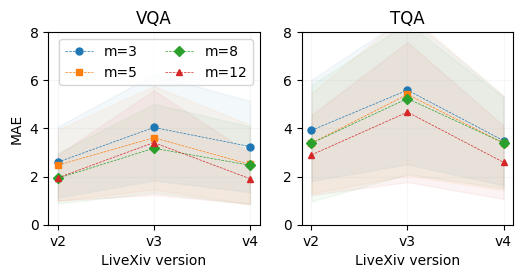

In [138]:
fig, axes = plt.subplots(1, len(names), figsize=(6, 2.5))
for i, name in enumerate(names):
    ax = axes[i]
    for m in ms:
        er = np.array([errors_dict[m][s][name][v]['domain'] for v in vs]).mean(-1)
        mad = er[:, 1]
        er = er[:, 0]
        ax.plot(vs, er, '--', lw=0.5, markersize=5, marker=marker_dict[m], color=color_dict[m], label=f"m={m}")
        ax.fill_between(vs, er-mad, er+mad, color=color_dict[m], alpha=.05)

    ax.set_xticks(vs)
    ax.set_xticklabels([f"v{v+1}" for v in vs])
    ax.set_ylim(0, 8)
    ax.set_xlabel('LiveXiv version')
    if i==0:ax.set_ylabel('MAE')
    ax.set_title({'vqa':'VQA','tqa':'TQA'}[name])
    ax.grid(alpha=.1)
    if i==0:ax.legend(ncol=2)
plt.savefig(f'../plots/summary_mae_domain-{s}.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

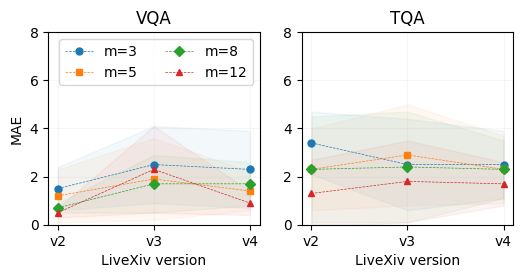

In [139]:
fig, axes = plt.subplots(1, len(names), figsize=(6, 2.5))
for i, name in enumerate(names):
    ax = axes[i]
    for m in ms:
        er = np.array([errors_dict[m][s][name][v]['overall'] for v in vs])
        mad = er[:, 1]
        er = er[:, 0]
        ax.plot(vs, er, '--', lw=0.5, markersize=5, marker=marker_dict[m], color=color_dict[m], label=f"m={m}")
        ax.fill_between(vs, er-mad, er+mad, color=color_dict[m], alpha=.05)

    ax.set_xticks(vs)
    ax.set_xticklabels([f"v{v+1}" for v in vs])
    ax.set_ylim(0, 8)
    ax.set_xlabel('LiveXiv version')
    if i==0:ax.set_ylabel('MAE')
    ax.set_title({'vqa':'VQA','tqa':'TQA'}[name])
    ax.grid(alpha=.1)
    if i==0:ax.legend(ncol=2)
plt.savefig(f'../plots/summary_mae_overall-{s}.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

Correlation plots

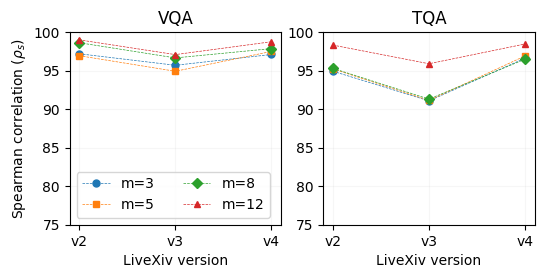

In [140]:
fig, axes = plt.subplots(1, len(names), figsize=(6, 2.5))
for i, name in enumerate(names):
    ax = axes[i]
    for m in ms:
        er = np.array([corrs_dict[m][s][name][v]['domain'] for v in vs]).mean(-1)
        ax.plot(vs, er, '--', lw=0.5, markersize=5, marker=marker_dict[m], color=color_dict[m], label=f"m={m}")
        
    ax.set_xticks(vs)
    ax.set_xticklabels([f"v{v+1}" for v in vs])
    ax.set_ylim(75, 100)
    ax.set_xlabel('LiveXiv version')
    if i==0:ax.set_ylabel('Spearman correlation ($\\rho_s$)')
    ax.set_title({'vqa':'VQA','tqa':'TQA'}[name])
    ax.grid(alpha=.1)
    if i==0:ax.legend(ncol=2)
plt.savefig(f'../plots/summary_corr_domain-{s}.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

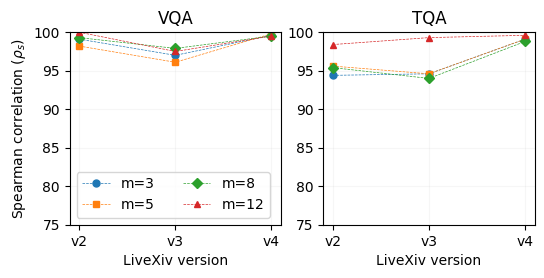

In [141]:
fig, axes = plt.subplots(1, len(names), figsize=(6, 2.5))
for i, name in enumerate(names):
    ax = axes[i]
    for m in ms:
        er = np.array([corrs_dict[m][s][name][v]['overall'] for v in vs])
        ax.plot(vs, er, '--', lw=0.5, markersize=5, marker=marker_dict[m], color=color_dict[m], label=f"m={m}")
        
    ax.set_xticks(vs)
    ax.set_xticklabels([f"v{v+1}" for v in vs])
    ax.set_ylim(75, 100)
    ax.set_xlabel('LiveXiv version')
    if i==0:ax.set_ylabel('Spearman correlation ($\\rho_s$)')
    ax.set_title({'vqa':'VQA','tqa':'TQA'}[name])
    ax.grid(alpha=.1)
    if i==0:ax.legend(ncol=2)
plt.savefig(f'../plots/summary_corr_overall-{s}.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

## Detailed plots

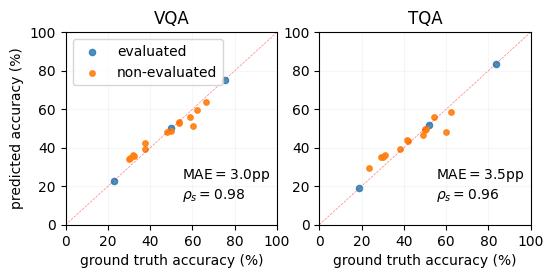

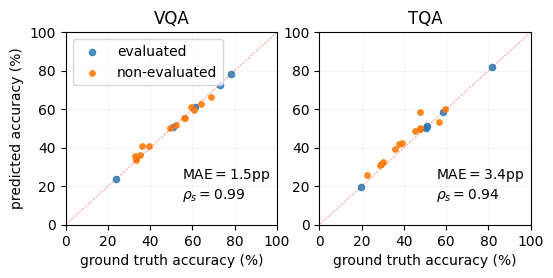

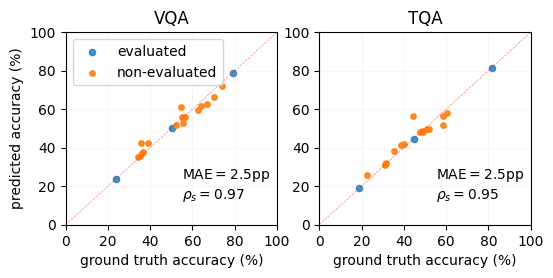

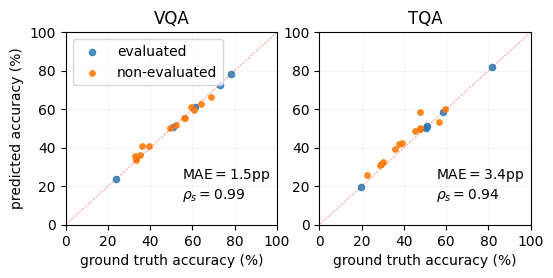

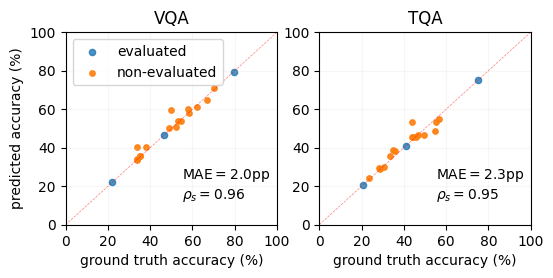

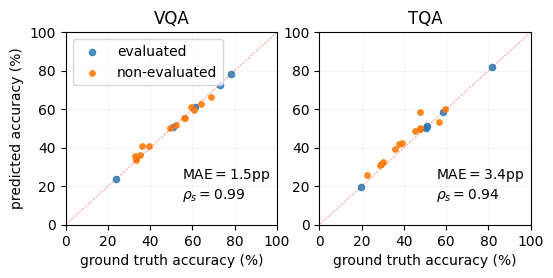

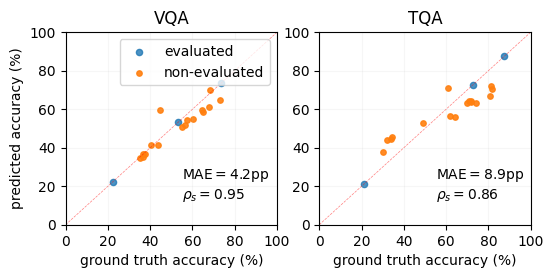

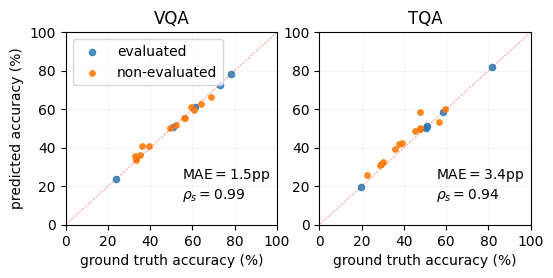

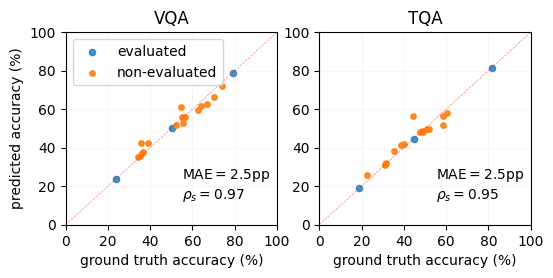

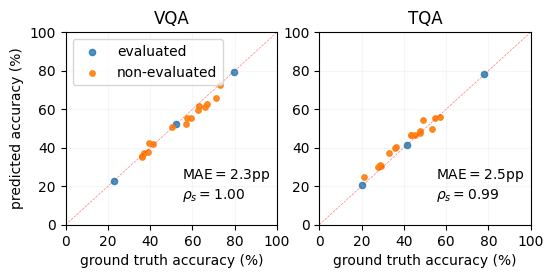

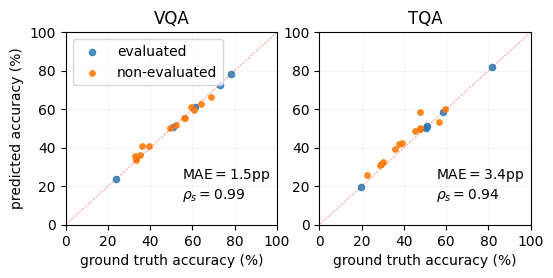

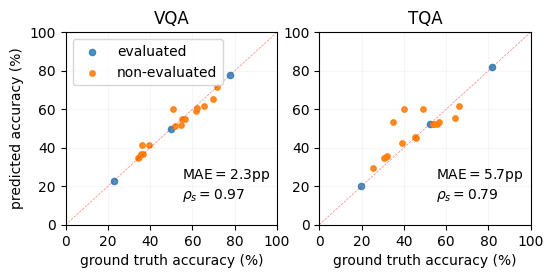

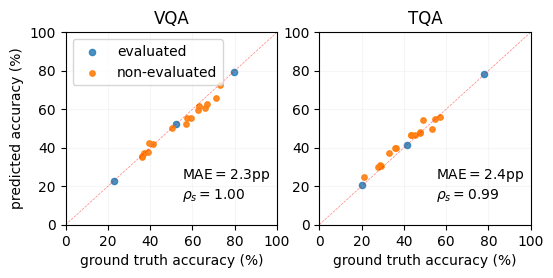

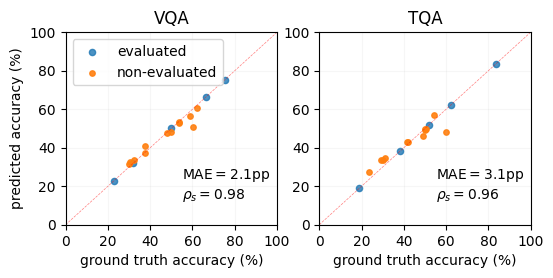

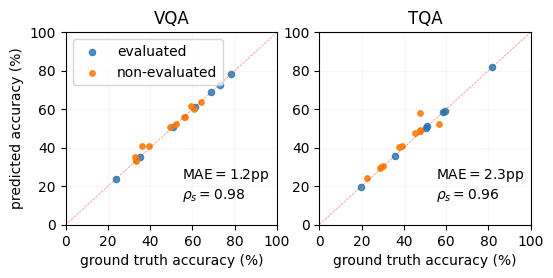

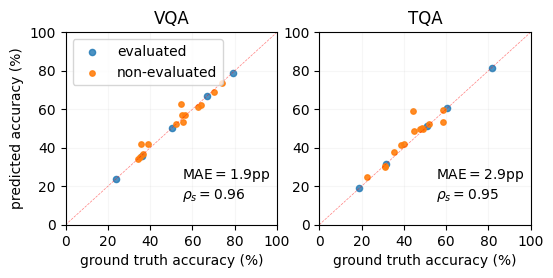

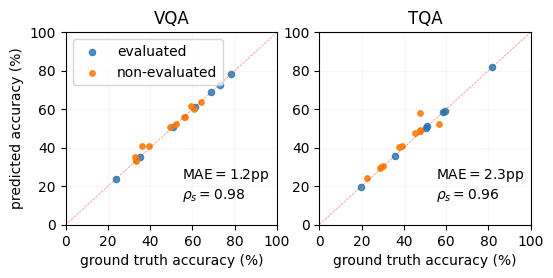

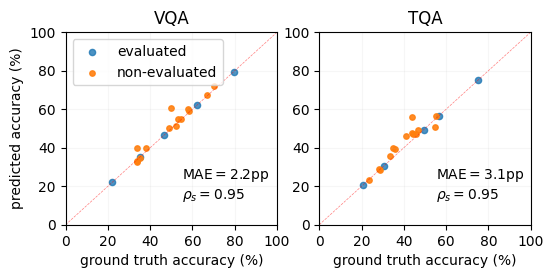

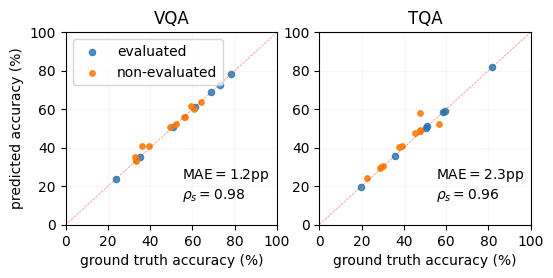

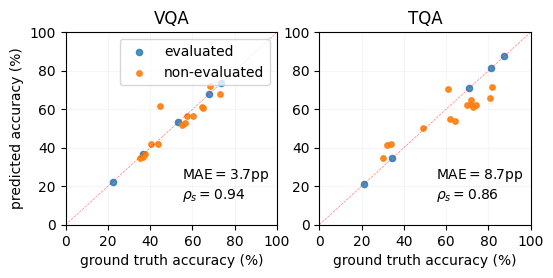

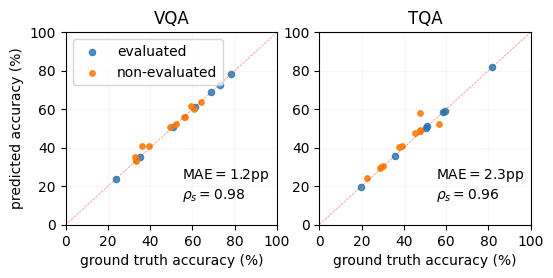

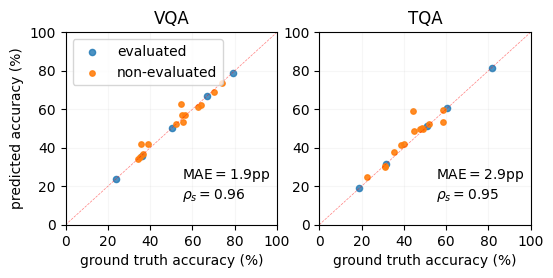

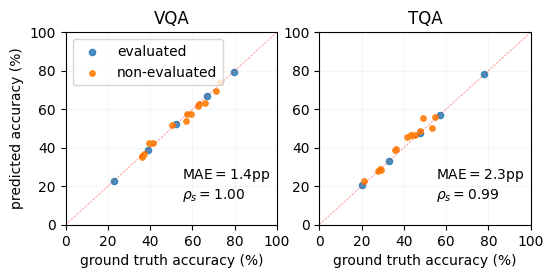

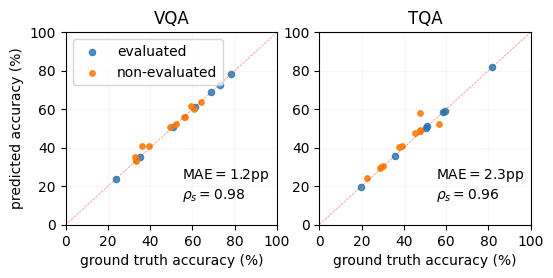

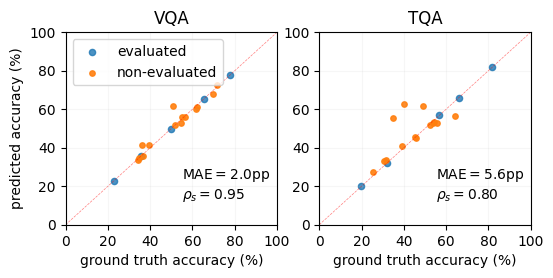

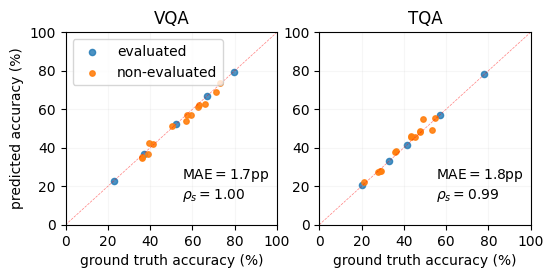

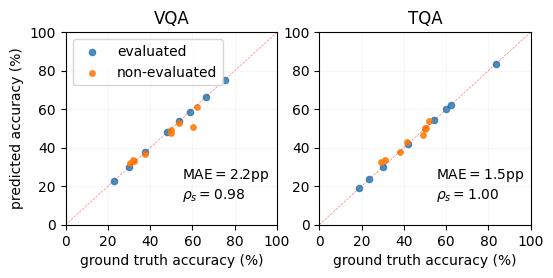

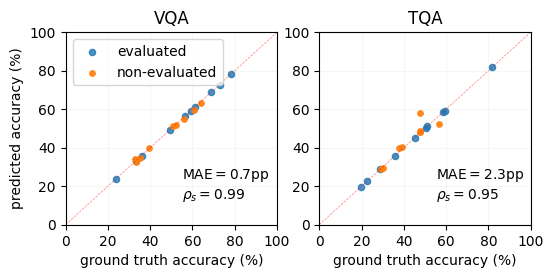

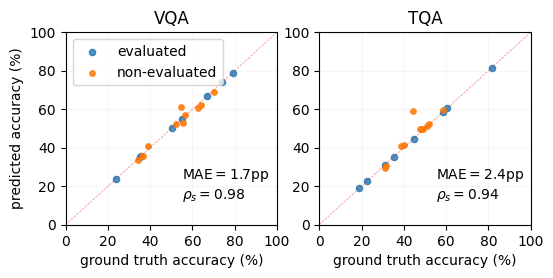

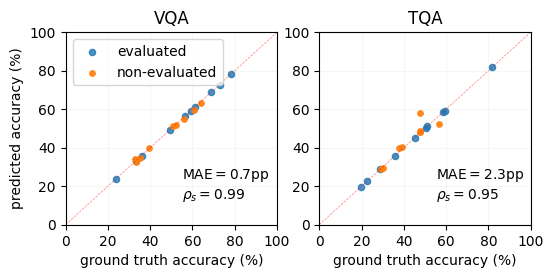

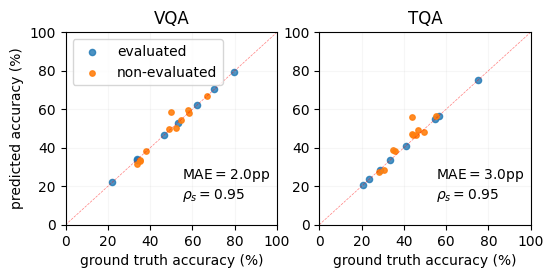

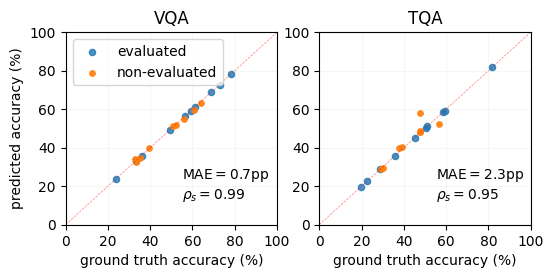

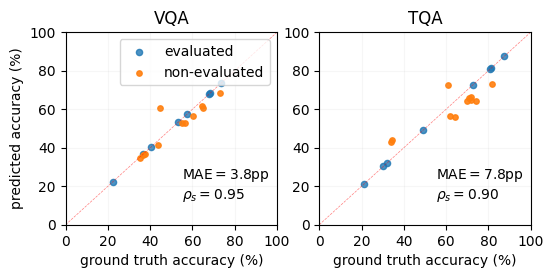

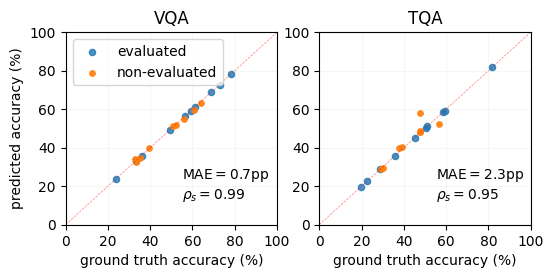

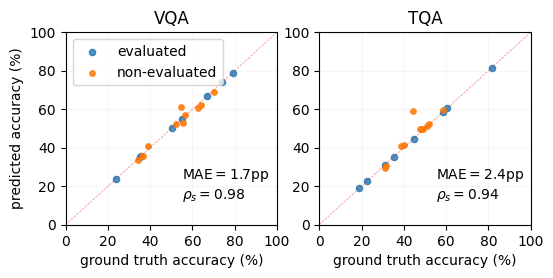

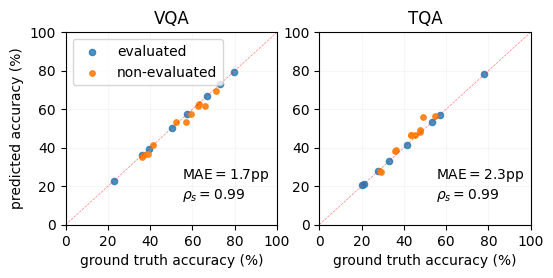

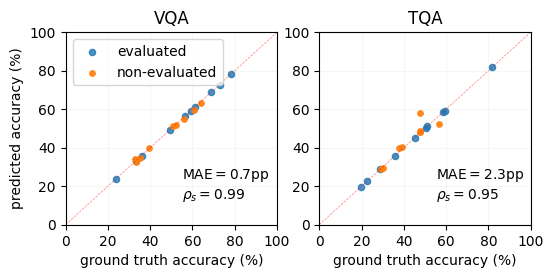

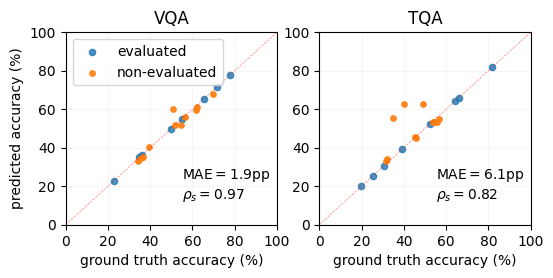

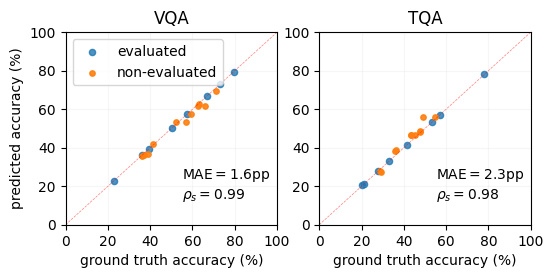

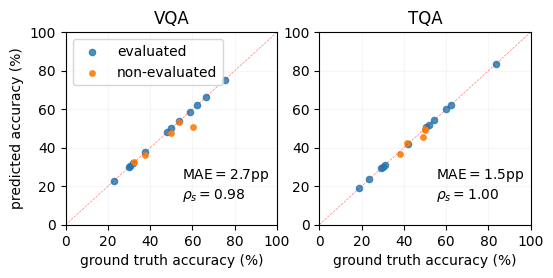

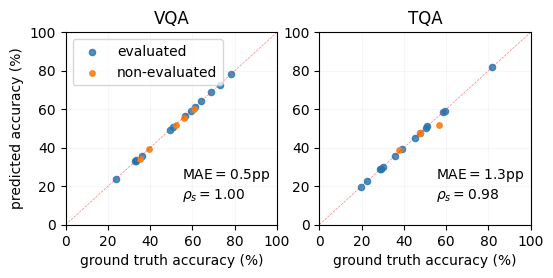

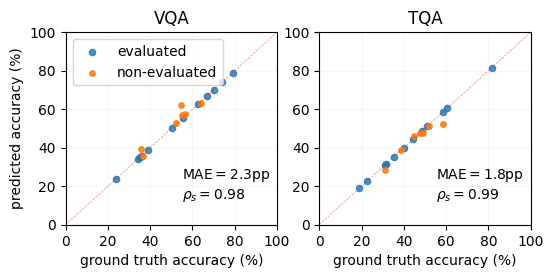

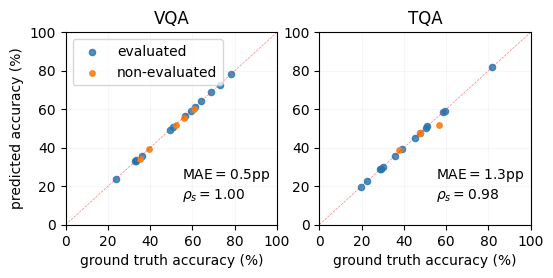

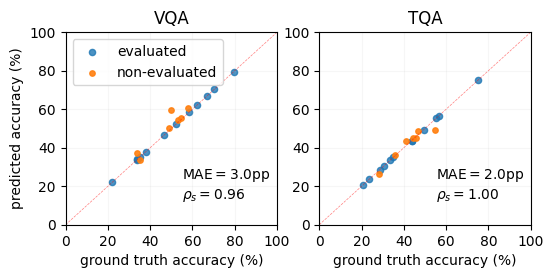

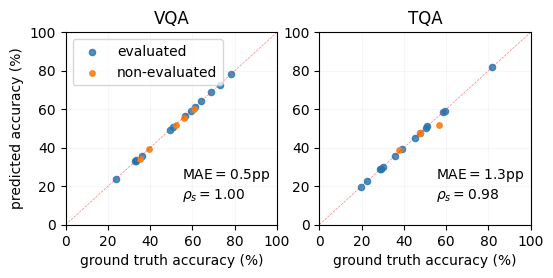

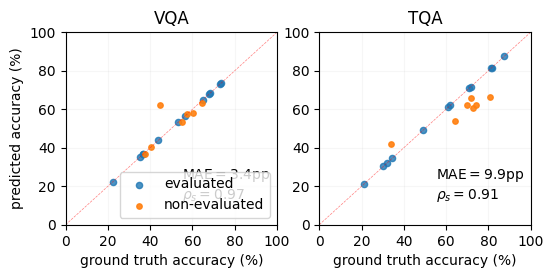

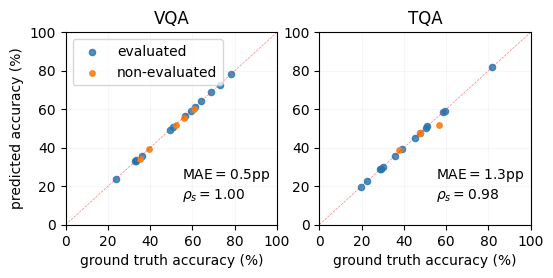

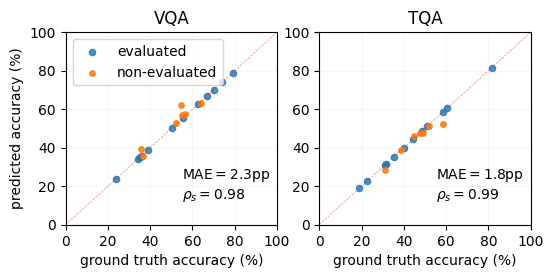

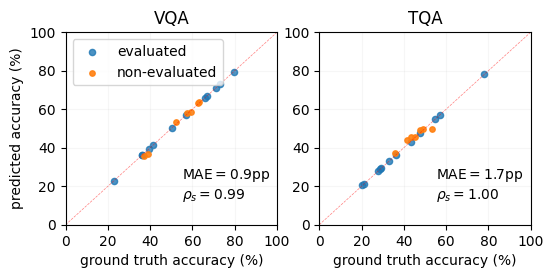

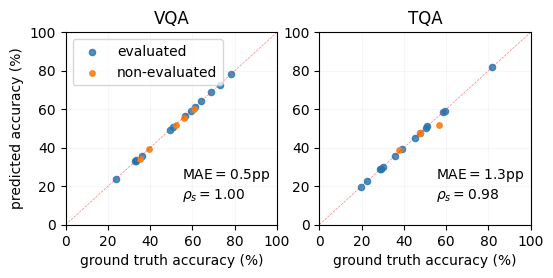

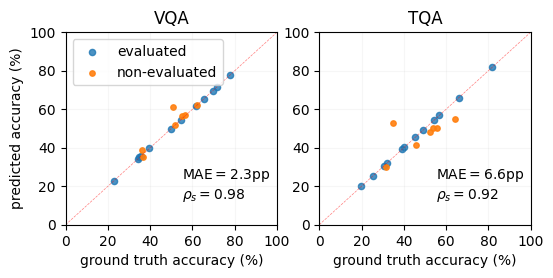

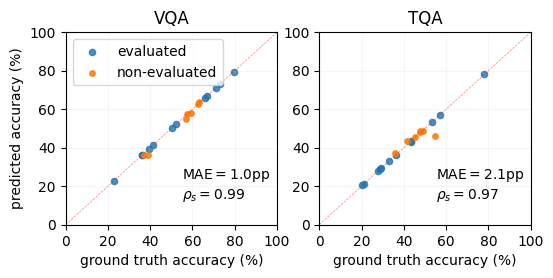

In [110]:
for m in ms:
    for versions in versions_list: #
        vs = list(range(len(versions)))
        for v,ver in zip(vs,versions):

            if v>0:
                fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))  # 1 row, 2 columns for side-by-side plots
                
                for i,name in enumerate(names):
                    acc, acc_hat = Ys[m]["_".join(versions)][name][v].mean(1), Ys_hat[m]["_".join(versions)][name][v].mean(1)
                    if versions[0]=='old':
                        ind = np.zeros(len(models_names)-2).astype(bool)
                    else:
                        ind = np.zeros(len(models_names)).astype(bool)
                    ind[models[m]["_".join(versions)][name][v]] = True
                    axes[i].scatter(acc[ind], acc_hat[ind], s=20, alpha=.80, label='evaluated')
                    axes[i].scatter(acc[~ind], acc_hat[~ind], s=15, alpha=.90, label='non-evaluated')
                    axes[i].plot([0, 100], [0, 100], 'r--', lw=.5, alpha=.5)
                    text = f'MAE$=${np.abs(acc-acc_hat)[~ind].mean():.1f}pp\n$\\rho_s=${spearmanr(acc, acc_hat).statistic:.2f}'
                    #axes[i].text(70, 20, text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.5))
                    axes[i].text(55, 13.5, text, fontsize=10, bbox=dict(facecolor='none', edgecolor='none'))
                    
                    axes[i].set_xlabel('ground truth accuracy (%)')
                    if i==0: axes[i].set_ylabel('predicted accuracy (%)')
                    axes[i].set_xlim(0,100)
                    axes[i].set_ylim(0,100)
                    axes[i].set_title({'vqa':'VQA','tqa':'TQA'}[name])
                    axes[i].grid(alpha=.1)
                    
                    if i==0: axes[i].legend()
                
                plt.savefig(f'../plots/versions={versions}_ver={ver}_m={m}.pdf', bbox_inches='tight', dpi=400, transparent=False)
                plt.show()